In [1]:
import os
import random
from pycocotools.coco import COCO
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Set random seed for reproducibility
random.seed(42)

# Define categories
categories = ['car', 'bus', 'truck', 'motorcycle']

# Paths
data_dir = '/kaggle/input/coco-2017-dataset/'
ann_file_train = os.path.join(data_dir,  'coco2017/annotations/instances_train2017.json')

# Load COCO annotations
coco = COCO(ann_file_train)

# Get category IDs
cat_ids = {cat: coco.getCatIds(catNms=[cat])[0] for cat in categories}

# Get image IDs per category
img_ids_per_cat = {cat: coco.getImgIds(catIds=[cat_ids[cat]]) for cat in categories}

# Randomly sample 2000 image IDs per category
selected_img_ids = set()
for cat in categories:
    sampled_ids = random.sample(img_ids_per_cat[cat], 2000)
    selected_img_ids.update(sampled_ids)

# If more than 8000, sample 8000
if len(selected_img_ids) > 8000:
    selected_img_ids = random.sample(list(selected_img_ids), 8000)
else:
    print(f"Warning: Only {len(selected_img_ids)} unique images selected, less than 8000.")

# Convert to list and shuffle
selected_img_ids = list(selected_img_ids)
random.shuffle(selected_img_ids)

# Split into test and train_dev
test_img_ids = selected_img_ids[:1000]
train_dev_img_ids = selected_img_ids[1000:]

print(f"Train/Dev images: {len(train_dev_img_ids)}")
print(f"Test images: {len(test_img_ids)}")

loading annotations into memory...
Done (t=19.14s)
creating index...
index created!
Train/Dev images: 6214
Test images: 1000


In [2]:
import os
import shutil
from pycocotools.coco import COCO

# Paths
data_dir = '/kaggle/input/coco-2017-dataset/coco2017'  # Correct base path for Kaggle dataset
ann_file_train = os.path.join(data_dir, 'annotations', 'instances_train2017.json')
ann_file_val = os.path.join(data_dir, 'annotations', 'instances_val2017.json')
img_dir_train = os.path.join(data_dir, 'train2017')
img_dir_val = os.path.join(data_dir, 'val2017')
output_dir = '/kaggle/working/custom_coco_dataset'  # Output in writable directory

# Verify paths exist
for path in [ann_file_train, ann_file_val, img_dir_train, img_dir_val]:
    if not os.path.exists(path):
        print(f"Error: Path not found: {path}")
        print("Available in /kaggle/input/coco-2017-dataset/coco2017:")
        print(os.listdir('/kaggle/input/coco-2017-dataset/coco2017'))
        raise FileNotFoundError(f"Ensure the COCO 2017 dataset is added correctly.")

# Create output directories
for split in ['train', 'val']:
    os.makedirs(os.path.join(output_dir, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels', split), exist_ok=True)

# Categories to filter
categories = ['car', 'bus', 'truck', 'motorcycle']

def process_split(ann_file, img_dir, split):
    print(f"Processing {split} split with annotation file: {ann_file}")
    coco = COCO(ann_file)
    cat_ids = coco.getCatIds(catNms=categories)
    class_map = {cat['id']: i for i, cat in enumerate(coco.loadCats(cat_ids)) if cat['name'] in categories}

    # Get image IDs with at least one target category
    img_ids = set()
    for cat_id in cat_ids:
        img_ids.update(coco.getImgIds(catIds=cat_id))

    print(f"Found {len(img_ids)} images with target categories in {split} split.")

    # Process each image
    for img_id in img_ids:
        img = coco.loadImgs(img_id)[0]
        img_path = os.path.join(img_dir, img['file_name'])
        label_path = os.path.join(output_dir, 'labels', split, img['file_name'].replace('.jpg', '.txt'))
        
        # Copy image
        shutil.copy(img_path, os.path.join(output_dir, 'images', split, img['file_name']))

        # Get and convert annotations
        ann_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(ann_ids)
        with open(label_path, 'w') as f:
            for ann in anns:
                if ann['category_id'] not in class_map:
                    continue
                class_id = class_map[ann['category_id']]
                bbox = ann['bbox']  # [x_min, y_min, width, height]
                x_center = (bbox[0] + bbox[2] / 2) / img['width']
                y_center = (bbox[1] + bbox[3] / 2) / img['height']
                width = bbox[2] / img['width']
                height = bbox[3] / img['height']
                f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

# Process train and val splits
process_split(ann_file_train, img_dir_train, 'train')
process_split(ann_file_val, img_dir_val, 'val')

print("Dataset preparation completed!")

Processing train split with annotation file: /kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json
loading annotations into memory...
Done (t=16.36s)
creating index...
index created!
Found 18175 images with target categories in train split.
Processing val split with annotation file: /kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json
loading annotations into memory...
Done (t=0.68s)
creating index...
index created!
Found 796 images with target categories in val split.
Dataset preparation completed!


In [3]:
import os
import random
import shutil
from pycocotools.coco import COCO

# Step 1: Prepare the Dataset
# Set random seed for reproducibility
random.seed(42)

# Paths for COCO dataset in Kaggle
data_dir = '/kaggle/input/coco-2017-dataset/coco2017'
ann_file_train = os.path.join(data_dir, 'annotations', 'instances_train2017.json')
img_dir_train = os.path.join(data_dir, 'train2017')
output_dir = '/kaggle/working/custom_coco_dataset'

# Verify paths
for path in [ann_file_train, img_dir_train]:
    if not os.path.exists(path):
        print(f"Error: Path not found: {path}")
        print(os.listdir('/kaggle/input/coco-2017-dataset/coco2017'))
        raise FileNotFoundError("Check dataset addition.")

# Create output directories (use 'train' and 'val' to match YOLOv5 convention)
for split in ['train', 'val']:
    os.makedirs(os.path.join(output_dir, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels', split), exist_ok=True)

# Categories
categories = ['car', 'bus', 'truck', 'motorcycle']

# Load annotations
coco = COCO(ann_file_train)
cat_ids = {cat: coco.getCatIds(catNms=[cat])[0] for cat in categories}

# Get image IDs per category
img_ids_per_cat = {cat: coco.getImgIds(catIds=[cat_ids[cat]]) for cat in categories}

# Sample 2000 images per category
selected_img_ids = set()
for cat in categories:
    sampled_ids = random.sample(img_ids_per_cat[cat], min(2000, len(img_ids_per_cat[cat])))
    selected_img_ids.update(sampled_ids)

# Adjust to 8000
if len(selected_img_ids) > 8000:
    selected_img_ids = random.sample(list(selected_img_ids), 8000)

selected_img_ids = list(selected_img_ids)
random.shuffle(selected_img_ids)

# Split: 7000 train, 1000 val
train_ids = selected_img_ids[:7000]
val_ids = selected_img_ids[7000:]

# Process images and annotations
def process_images(img_ids, split):
    class_map = {cat['id']: i for i, cat in enumerate(coco.loadCats(cat_ids.values())) if cat['name'] in categories}
    for img_id in img_ids:
        img = coco.loadImgs(img_id)[0]
        img_path = os.path.join(img_dir_train, img['file_name'])
        label_path = os.path.join(output_dir, 'labels', split, img['file_name'].replace('.jpg', '.txt'))
        shutil.copy(img_path, os.path.join(output_dir, 'images', split, img['file_name']))
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=list(cat_ids.values()))
        anns = coco.loadAnns(ann_ids)
        with open(label_path, 'w') as f:
            for ann in anns:
                if ann['category_id'] not in class_map:
                    continue
                class_id = class_map[ann['category_id']]
                bbox = ann['bbox']
                x_center = (bbox[0] + bbox[2] / 2) / img['width']
                y_center = (bbox[1] + bbox[3] / 2) / img['height']
                width = bbox[2] / img['width']
                height = bbox[3] / img['height']
                f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

process_images(train_ids, 'train')
process_images(val_ids, 'val')

print(f"Dataset prepared: {len(train_ids)} train, {len(val_ids)} val images.")

# Step 2: Set Up YOLOv5
# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

# Install dependencies
!pip install -r requirements.txt

# Create custom_coco.yaml in yolov5 directory
yaml_content = """
train: /kaggle/working/custom_coco_dataset/images/train
val: /kaggle/working/custom_coco_dataset/images/val
nc: 4
names: ['car', 'bus', 'truck', 'motorcycle']
"""
with open('custom_coco.yaml', 'w') as f:
    f.write(yaml_content)

# Step 3: Train YOLOv5
!python train.py --img 640 --batch 16 --epochs 10 --data custom_coco.yaml --weights yolov5s.pt --project /kaggle/working/vehicle_detection --name run1

print("Training completed!")

loading annotations into memory...
Done (t=16.13s)
creating index...
index created!
Dataset prepared: 7000 train, 214 val images.
Cloning into 'yolov5'...
remote: Enumerating objects: 17360, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 17360 (delta 36), reused 18 (delta 18), pack-reused 17308 (from 2)
Receiving objects: 100% (17360/17360), 16.25 MiB | 29.77 MiB/s, done.
Resolving deltas: 100% (11901/11901), done.
/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 977.3/977.3 kB 17.8 MB/s eta 0:00:00a 0:00:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See suppor

In [4]:
import torch
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from lime import lime_image
import random

# Load trained YOLOv5 model
weights_path = '/kaggle/working/vehicle_detection/run1/weights/best.pt'
if not os.path.exists(weights_path):
    raise FileNotFoundError(f"Weights file not found at {weights_path}")
print(f"Loading model from {weights_path}")
model = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_path)

# Load images from validation set
image_dir = '/kaggle/working/custom_coco_dataset/images/val'
image_files = os.listdir(image_dir)
if not image_files:
    raise FileNotFoundError(f"No images found in {image_dir}")

# Define categories
categories = ['car', 'bus', 'truck', 'motorcycle']
num_samples = 4  # Number of images per category
category_images = {cat: [] for cat in categories}

# Process images and classify by detected objects
for img_file in image_files:
    image_path = os.path.join(image_dir, img_file)
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    results = model(image_np)
    detections = results.pandas().xyxy[0]
    
    for cat in categories:
        cat_dets = detections[detections['name'] == cat]
        if not cat_dets.empty and len(category_images[cat]) < num_samples:
            category_images[cat].append((image_path, image_np, cat_dets.iloc[0]))
    
    if all(len(v) >= num_samples for v in category_images.values()):
        break  # Stop once we have enough images

# Define IoU function
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    xx1, yy1, xx2, yy2 = box2
    xi1 = max(x1, xx1)
    yi1 = max(y1, yy1)
    xi2 = min(x2, xx2)
    yi2 = min(y2, yy2)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (xx2 - xx1) * (yy2 - yy1)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# LIME explanation
explainer = lime_image.LimeImageExplainer()
fig, axes = plt.subplots(len(categories), num_samples, figsize=(15, 10))

for row, category in enumerate(categories):
    for col, (image_path, image_np, target_det) in enumerate(category_images[category]):
        original_bbox = target_det[['xmin', 'ymin', 'xmax', 'ymax']].values
        class_id = {'car': 0, 'bus': 1, 'truck': 2, 'motorcycle': 3}[target_det['name']]

        # Prediction function for LIME
        def predict_fn(images):
            predictions = []
            for img in images:
                results = model(img)
                dets = results.pandas().xyxy[0]
                class_dets = dets[dets['class'] == class_id]
                ious = [compute_iou(original_bbox, [det.xmin, det.ymin, det.xmax, det.ymax]) for det in class_dets.itertuples()]
                confs = [det.confidence for det, iou in zip(class_dets.itertuples(), ious) if iou > 0.4]
                max_conf = max(confs) if confs else 0
                predictions.append([1 - max_conf, max_conf])
            return np.array(predictions)

        # Apply LIME
        explanation = explainer.explain_instance(image_np, predict_fn, top_labels=1, hide_color=0, num_samples=500)
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)

        # Plot results
        axes[row, col].imshow(image_np)
        axes[row, col].imshow(mask, alpha=0.5, cmap='jet')
        axes[row, col].set_title(f"{category} - {col+1}")
        axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/lime_explanation_grid.png')  # Save the visualization
plt.show()
print("LIME saliency visualization saved to /kaggle/working/lime_explanation_grid.png")


Loading model from /kaggle/working/vehicle_detection/run1/weights/best.pt


/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-4-4 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

LIME saliency visualization saved to /kaggle/working/lime_explanation_grid.png


Loading model from /kaggle/working/vehicle_detection/run1/weights/best.pt


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-4-4 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Loading image: /kaggle/working/custom_coco_dataset/images/val/000000528980.jpg
Running inference...
Detections:
          xmin        ymin        xmax        ymax  confidence  class name
0   13.726280  616.810791   97.281700  639.712402    0.809886      0  car
1   82.250488  607.011108  183.429047  640.000000    0.753978      0  car
2  129.264801  575.676331  182.180389  594.150940    0.522848      0  car
3   56.877731  581.633789  102.249619  595.497925    0.427453      0  car
4  159.711136  576.702148  182.489182  591.502808    0.264134      0  car
5   70.682968  593.432007  141.693832  618.582642    0.251427      0  car
Selected detection: car (class 0) at [13.726280212402344 616.810791015625 97.28170013427734 639.71240234375]
Running LIME explanation...


  0%|          | 0/500 [00:00<?, ?it/s]

LIME explanation completed.


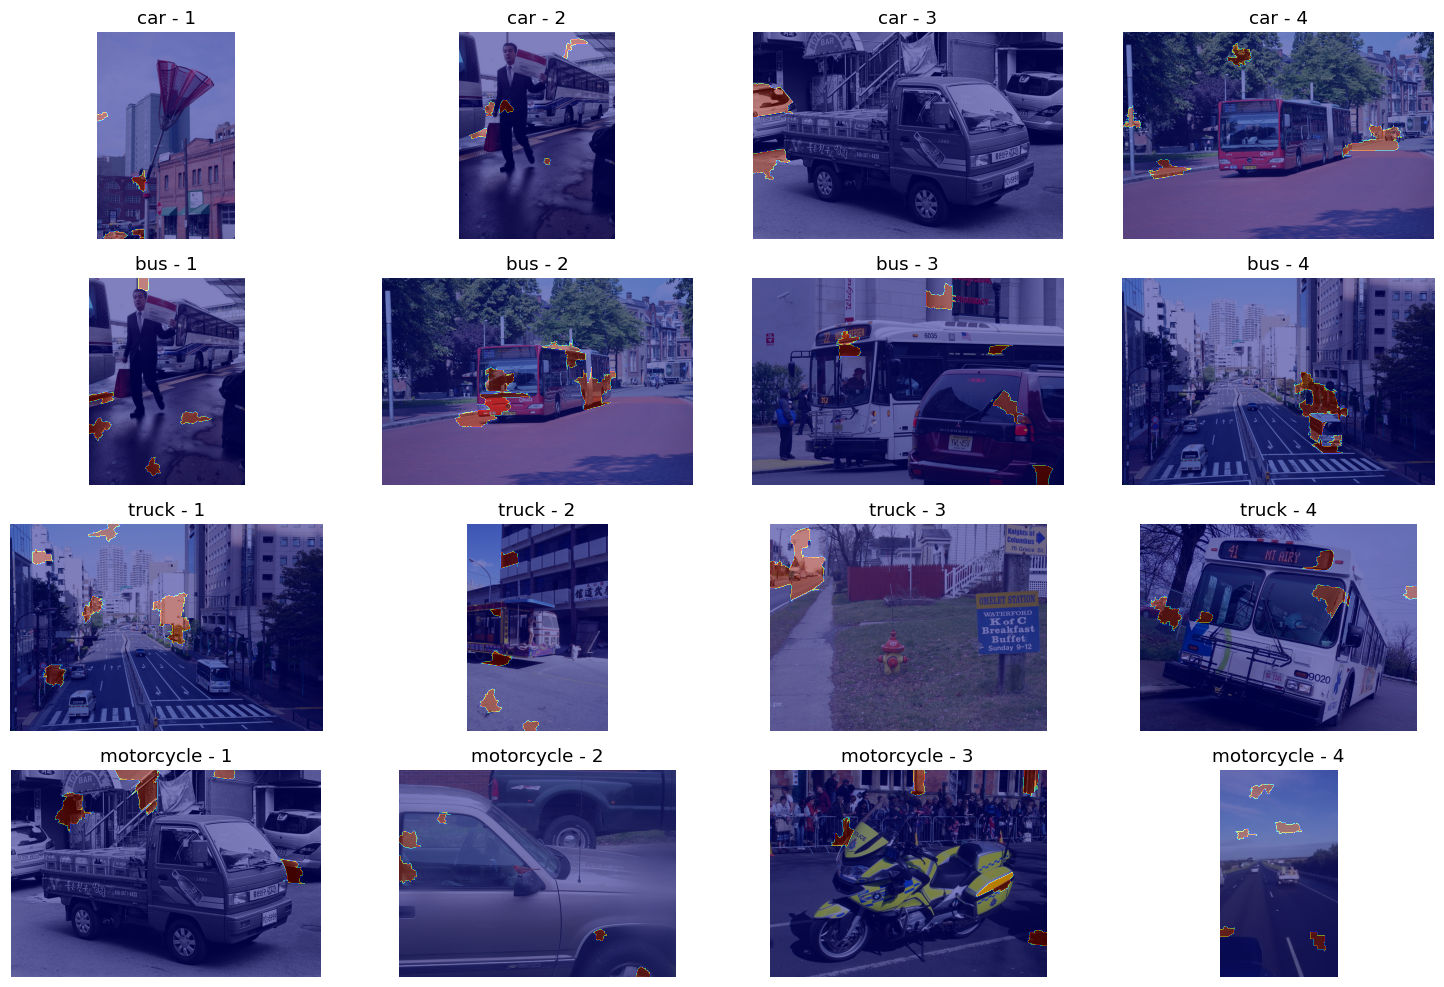

In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from lime import lime_image
import os

# Ensure matplotlib inline for Kaggle
%matplotlib inline

# Load trained YOLOv5 model
weights_path = '/kaggle/working/vehicle_detection/run1/weights/best.pt'
if not os.path.exists(weights_path):
    raise FileNotFoundError(f"Weights file not found at {weights_path}")
print(f"Loading model from {weights_path}")
model = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_path)

# Load a sample image from the validation set
image_dir = '/kaggle/working/custom_coco_dataset/images/val'
image_files = os.listdir(image_dir)
if not image_files:
    raise FileNotFoundError(f"No images found in {image_dir}")
image_path = os.path.join(image_dir, image_files[0])
print(f"Loading image: {image_path}")
image = Image.open(image_path).convert('RGB')
image_np = np.array(image)

# Perform inference
print("Running inference...")
results = model(image_np)
detections = results.pandas().xyxy[0]
print("Detections:\n", detections)

# Select a detection (e.g., first 'car')
car_dets = detections[detections['name'] == 'car']
if car_dets.empty:
    print("No 'car' detected. Falling back to first detection.")
    if detections.empty:
        raise ValueError("No detections found! Check model or image.")
    target_det = detections.iloc[0]
else:
    target_det = car_dets.iloc[0]
original_bbox = target_det[['xmin', 'ymin', 'xmax', 'ymax']].values
class_id = {'car': 0, 'bus': 1, 'truck': 2, 'motorcycle': 3}[target_det['name']]
print(f"Selected detection: {target_det['name']} (class {class_id}) at {original_bbox}")

# Define IoU function
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    xx1, yy1, xx2, yy2 = box2
    xi1 = max(x1, xx1)
    yi1 = max(y1, yy1)
    xi2 = min(x2, xx2)
    yi2 = min(y2, yy2)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (xx2 - xx1) * (yy2 - yy1)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# Prediction function for LIME
def predict_fn(images):
    predictions = []
    for img in images:
        results = model(img)
        dets = results.pandas().xyxy[0]
        class_dets = dets[dets['class'] == class_id]
        ious = [compute_iou(original_bbox, [det.xmin, det.ymin, det.xmax, det.ymax]) for det in class_dets.itertuples()]
        confs = [det.confidence for det, iou in zip(class_dets.itertuples(), ious) if iou > 0.4]
        max_conf = max(confs) if confs else 0
        predictions.append([1 - max_conf, max_conf])
    return np.array(predictions)

# Apply LIME
print("Running LIME explanation...")
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image_np, predict_fn, top_labels=1, hide_color=0, num_samples=500)  # Reduced samples for speed
print("LIME explanation completed.")

# Visualize explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.figure(figsize=(8, 8))
plt.imshow(image_np)
plt.imshow(mask, alpha=0.5, cmap='jet')
plt.title(f"LIME Explanation for {target_det['name']} Detection")
plt.axis('off')
plt.savefig('/kaggle/working/lime_explanation.png')  # Save to file for Kaggle
plt.show()  # Attempt to display inline
print("Visualization saved to /kaggle/working/lime_explanation.png")

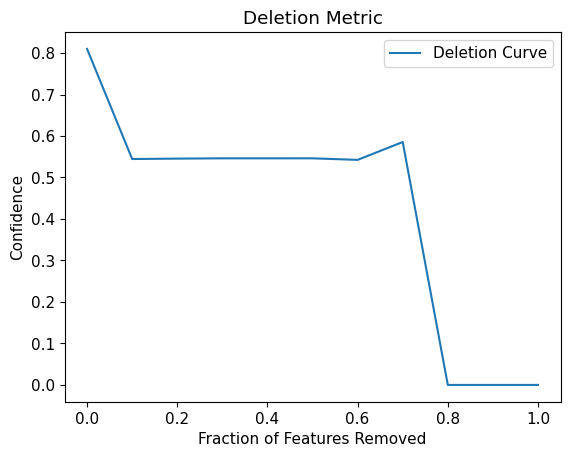

Deletion AUC: 0.426 (lower is better)


In [11]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def deletion_metric(model, image_np, explanation, target_class_id, original_conf, steps=10):
    mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)[1]
    feature_importance = mask.flatten()
    sorted_indices = np.argsort(feature_importance)[::-1]  # Sort by importance (descending)
    step_size = len(sorted_indices) // steps
    confidences = [original_conf]
    
    for i in range(1, steps + 1):
        mask_indices = sorted_indices[:i * step_size]
        perturbed_image = image_np.copy()
        perturbed_image.reshape(-1, 3)[mask_indices] = 0  # Mask to black
        results = model(perturbed_image)
        dets = results.pandas().xyxy[0]
        class_dets = dets[dets['class'] == target_class_id]
        conf = max(class_dets['confidence']) if not class_dets.empty else 0
        confidences.append(conf)
    
    # Compute AUC (trapezoidal rule)
    auc = np.trapz(confidences, dx=1/steps)
    plt.plot(np.linspace(0, 1, steps + 1), confidences, label='Deletion Curve')
    plt.xlabel('Fraction of Features Removed')
    plt.ylabel('Confidence')
    plt.title('Deletion Metric')
    plt.legend()
    plt.savefig('/kaggle/working/deletion_curve.png')
    plt.show()
    return auc

# Example usage
original_conf = target_det['confidence']
deletion_auc = deletion_metric(model, image_np, explanation, class_id, original_conf)
print(f"Deletion AUC: {deletion_auc:.3f} (lower is better)")

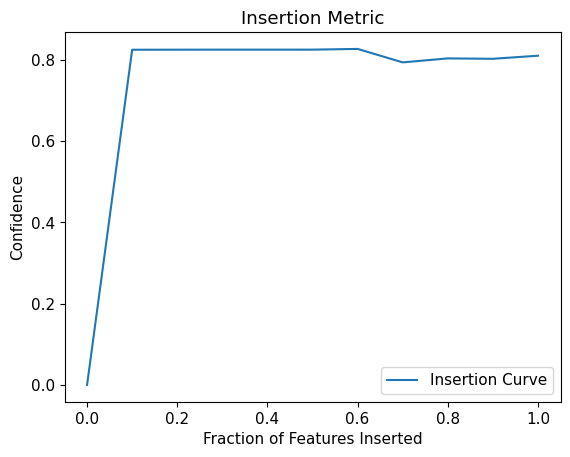

Insertion AUC: 0.775 (higher is better)


In [7]:
def insertion_metric(model, image_np, explanation, target_class_id, steps=10):
    mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)[1]
    feature_importance = mask.flatten()
    sorted_indices = np.argsort(feature_importance)[::-1]  # Sort by importance (descending)
    step_size = len(sorted_indices) // steps
    confidences = []
    base_image = np.zeros_like(image_np)  # Start with black image
    
    for i in range(steps + 1):
        mask_indices = sorted_indices[:i * step_size]
        perturbed_image = base_image.copy()
        perturbed_image.reshape(-1, 3)[mask_indices] = image_np.reshape(-1, 3)[mask_indices]
        results = model(perturbed_image)
        dets = results.pandas().xyxy[0]
        class_dets = dets[dets['class'] == target_class_id]
        conf = max(class_dets['confidence']) if not class_dets.empty else 0
        confidences.append(conf)
    
    # Compute AUC
    auc = np.trapz(confidences, dx=1/steps)
    plt.plot(np.linspace(0, 1, steps + 1), confidences, label='Insertion Curve')
    plt.xlabel('Fraction of Features Inserted')
    plt.ylabel('Confidence')
    plt.title('Insertion Metric')
    plt.legend()
    plt.savefig('/kaggle/working/insertion_curve.png')
    plt.show()
    return auc

# Example usage
insertion_auc = insertion_metric(model, image_np, explanation, class_id)
print(f"Insertion AUC: {insertion_auc:.3f} (higher is better)")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

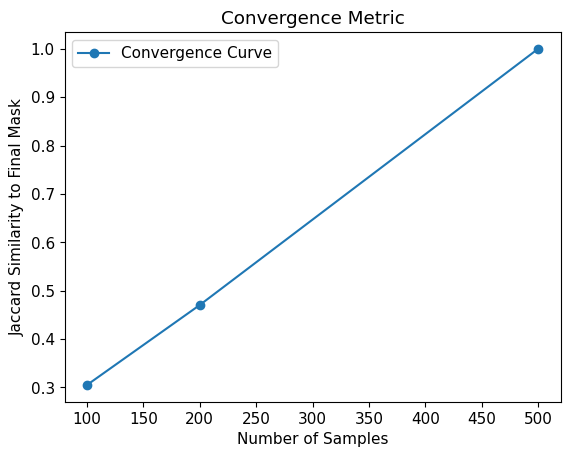

Convergence Similarities: [0.30500214992116953, 0.4703563544623147, 1.0]


In [8]:
def convergence_metric(image_np, predict_fn, sample_sizes=[100, 200, 500, 1000]):
    explainer = lime_image.LimeImageExplainer()
    masks = []
    for size in sample_sizes:
        explanation = explainer.explain_instance(image_np, predict_fn, top_labels=1, num_samples=size)
        mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5)[1]
        masks.append(mask.flatten())
    
    final_mask = masks[-1]
    similarities = []
    for mask in masks[:-1]:
        intersect = np.sum(mask & final_mask)
        union = np.sum(mask | final_mask)
        similarities.append(intersect / union if union > 0 else 1)
    
    plt.plot(sample_sizes[:-1], similarities, marker='o', label='Convergence Curve')
    plt.xlabel('Number of Samples')
    plt.ylabel('Jaccard Similarity to Final Mask')
    plt.title('Convergence Metric')
    plt.legend()
    plt.savefig('/kaggle/working/convergence_curve.png')
    plt.show()
    return similarities

# Example usage
convergence_scores = convergence_metric(image_np, predict_fn)
print(f"Convergence Similarities: {convergence_scores}")